### Exercise 2b)

In [170]:
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import GradientDescent, StochasticGradientDescent
from utils.step_methods import ConstantLearningRateStep, MomentumStep, ADAgradStep, RMSpropStep, AdamStep
from utils.cost_functions import SoftmaxCrossEntropy,MSE
from utils.activation_functions import Sigmoid, Identity
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [171]:
def runge(x): 
    return 1/(1 + 25*x**2)

np.random.seed(124)

n = 500
x = np.random.uniform(-1, 1, n)
y = runge(x) + 0.05*np.random.normal(0, 1, n)
x = x.reshape(-1,1)
y = y.reshape(-1,1)
#x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y.reshape(-1,1), test_size=0.2,random_state = 44)
y_mean = y.mean()

n_folds = 5

model = LinearRegression(fit_intercept=False)

model = make_pipeline(PolynomialFeatures(degree=12, include_bias=False), StandardScaler(), model)

kfold = KFold(n_splits=n_folds,shuffle=True,random_state=44)
estimated_mse_folds = cross_val_score(model, x, y - y_mean, scoring='neg_mean_squared_error', cv=kfold)
mse_OLS = np.mean(-estimated_mse_folds)

print("Testing MSE for OLS linear regression: ",mse_OLS)

network_input_size = 1
network_output_size = 1

layer_output_sizes = [10, 10, network_output_size]
activation_funcs = [Sigmoid(), Sigmoid(), Identity()]

no_train_mse = np.zeros(n_folds)
train_mse = np.zeros(n_folds)

for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
    net = NeuralNetwork(network_input_size,
        layer_output_sizes,
        activation_funcs,
        MSE(),
    )
    x_train = x[train_idx]
    x_test = x[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    no_train_mse[fold_idx] = net.cost_batch(x_test,y_test - y_mean)
    net.train(StochasticGradientDescent(step_method=RMSpropStep(learning_rate=0.01, decay_rate=0.9),inputs = x_train, targets = y_train - y_mean),3000)
    train_mse[fold_idx] = net.cost_batch(x_test,y_test - y_mean)

print("Testing MSE for neural network before training: ",np.mean(no_train_mse))

print("Testing MSE for neural network after training: ",np.mean(train_mse))


Testing MSE for OLS linear regression:  0.0033770536380409886
Testing MSE for neural network before training:  3.0841724629394585
Testing MSE for neural network after training:  0.0027259402575312086


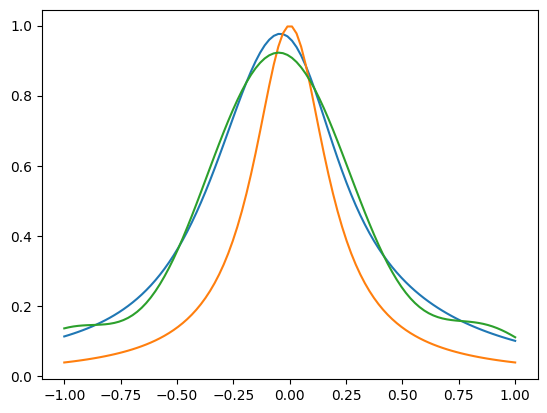

In [172]:
x_test = np.linspace(-1,1, 100)
y_pred = net.predict(x_test.reshape(-1, 1)) + y_mean

model = LinearRegression(fit_intercept=False)

model = make_pipeline(PolynomialFeatures(degree=12, include_bias=False), StandardScaler(), model)

plt.plot(x_test,y_pred)
plt.plot(x_test,runge(x_test))
plt.plot(x_test,model.fit(x_train.reshape(-1,1), y_train - y_mean).predict(x_test.reshape(-1,1)) + y_mean)
plt.show()